# Olympics data with SQL and pandas- home games
> What is the effect of a home Olympic games

- toc: true
- badges: true
- comments: true
- categories: [SQL, Pandas, python, Olympics]

![](ghtop_images/header2.png)

## Overview

This is part of a project that looks at an Olympics dataset.

In this part the hypothesis considered is:

    At a home Olympic games a nation will on average obtain more medals than at other games
    
- But can we quantify this effect? 
- Are there any residual effects before and after the games?
- What about a home continent games?
    
    
## Methodology

To be able to answer the question, the steps taken are as follows. Note the data and tables created in a previous page.

- Create table of medal athletes as `athlete`
    - `Medals`
    - `Year`
    - `NOC`
    - *Others? `Sex`, `number_of_athletes`*
- Join `athlete` table to `country` table to get the country added to `athlete`

Now the next step is trickier. There are several ways we could look at the effect of a home game and the nearness to it. The way I like to do this is to visualise the plot(s) I would like and work back from that.

The plot I'd like is:
- x-axis = year from games (0 = at the games, +ve after and -ve before)
- y-axis = number of medals

If we normalise the y-axis we can put all the events together to get an effect of games, before and after. We can also pick out individual games or do the averageing on different time-periods.

So to achieve this we need a vector for each games of:
- Year from games
- Number of medals

There are a number of potential problems with this:
1. If a nation holds two games close to each other
1. Normally games are every 4 years but how do we deal with exceptions to this?
1. What do we do when there is a lack of data before or after the games? e.g. games at the start of Olympics or current games, or if a nation stops partipation
1. When looking at the effect of continent, the approach would need to be adjusted based on there being fewer continents and most games being in Europe

(1) can be solved by reducing the times to +- 20 years, and because we are averageing any exceptions should be covered

(2) a way to solve this is to fit the data across the years/medals data we have with a function then use the function to give us values on a set scale (e.g. -20 to 20 in steps of 4 yrs)

(3) a bit trickier, may we fit values that have positive and negative values up to 20 yrs first. Then if an event has a gap in years fill with the average values below and above 0 yrs

(4) for this maybe just look at a partcular game based on recent games that are not in the same continent

## Some Starting Code

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandasql import sqldf
import copy
import numpy as np
import scipy.stats

In [2]:
df_F_S =pd.read_csv('data/athlete_F_S')
df_F_W=pd.read_csv('data/athlete_F_W')
df_M_S=pd.read_csv('data/athlete_M_S')
df_M_W=pd.read_csv('data/athlete_M_W')

df_all_athletes= pd.read_csv('data/all_athletes')
df_country= pd.read_csv('data/country')
# df_event= pd.read_csv('data/event')
df_games= pd.read_csv('data/games')
# df_population= pd.read_csv('data/population')

df_country = df_country.groupby('NOC').max()
# df_country.head(10)

In [7]:
df_games.head()

,Unnamed: 0,games_id,City,Country,Year,Region,Summer,Winter,Latitude,Longitude
0,0,0,Athens,Greece,1896,Europe,1,0,37.9838,23.7275
1,1,1,Paris,France,1900,Europe,1,0,48.8566,2.3522
2,2,2,St. Louis,USA,1904,North America,1,0,38.6270,90.1994
3,3,3,Athens,Greece,1906,Europe,1,0,37.9838,23.7275
4,4,4,London,UK,1908,Europe,1,0,51.5072,0.1276


## Create a table of Country & Medals

This first step is to create a table of athletes data that includes both women and men athletes from the summer games, we want the following columns:
- The Olympic Year 
- The Nation
- The Continent of the Nation
- The number of medals the nation got that year

Basically just `UNION` to join the male and female athletes- with some additions so we get the total number of medals per country

Followed by a `JOIN` on the `country` table to get more information about the countries.

In [3]:
def number_of_medals(df_F_S,df_M_S):
    testa2=sqldf('\
        SELECT                                                         \
            COUNT(*)              AS number_of_medals,                 \
            Year, NOC                                                  \
        FROM                                                           \
        (SELECT NOC,Year,COUNT(*) AS counta                            \
           FROM                                                        \
             (SELECT                                                   \
             athlete_ID,                                               \
             event_ID,                                                 \
             Medal_Gold,Medal_Silver,Medal_Bronze,                     \
             Year,                                                     \
             NOC                                                       \
             from df_F_S                                               \
             WHERE Medal_Gold=1 OR Medal_Silver=1 OR Medal_Bronze=1    \
             UNION ALL                                                 \
             SELECT                                                    \
             athlete_ID,                                               \
             event_ID,                                                 \
             Medal_Gold,Medal_Silver,Medal_Bronze,                     \
             Year,                                                     \
             NOC                                                       \
             from df_M_S                                               \
             WHERE Medal_Gold=1 OR Medal_Silver=1 OR Medal_Bronze=1    \
             order by Year asc) A                                      \
           GROUP BY                                                    \
             Year, NOC,event_id,Medal_Gold,Medal_Silver,Medal_Bronze)  AS B\
         GROUP BY Year, NOC                                            \
                 ;',locals()  )                                       
    return testa2

def join_country(df_,df_country):
    testa2=sqldf('\
        SELECT                             \
            c.NOC,c.Nation,c.Continent,    \
            a.number_of_medals,            \
            a.Year                         \
        FROM                               \
            df_ AS a                       \
        INNER JOIN                         \
            df_country AS c                \
        ON                                 \
            c.NOC=a.NOC                    \
        GROUP BY                           \
            c.NOC,a.Year                   \
     ;',locals()  ) 
    return testa2

df_medals=number_of_medals(df_F_S,df_M_S)
df_medals2=join_country(df_medals,df_country)
df_medals2.head()

,NOC,Nation,Continent,number_of_medals,Year
0,AFG,Afghanistan,Asia,1,2008
1,AFG,Afghanistan,Asia,1,2012
2,ALG,Algeria,Africa,2,1984
3,ALG,Algeria,Africa,2,1992
4,ALG,Algeria,Africa,3,1996


## Find the change in medals around a home games

The *easy* solution here would be to take an average of the medals a country obtains obtains at a home games versus non-home games. However, this wouldn't work mainly due to the changes in medals with time (they increase). 

We could correct for overall changes in the number of medals by normalising based on the total number of medals in a games. This would be better, but we may need an extra step to account for the lack of diversity of nations in earlier years too.

But also we wouldn't be able to see what effect a home games had before and after the games were held.

To observe how medal count is effected before and after a games, and to somewhat reduce the increase in medals with time, the following steps are taken.

1. Scoll through the `games` table for each summer games
2. For each game add data to the following variables (of length of the number of games) for each particular games
    - `nation` the nation hosting the particular games
    - `medals` the number of medals for each games for the nation hosting the particular games, in all the other games
    - `years` the difference in years between the particular games and all other games
    
For example:

USA 1984, Los Angeles

- `nation[20]` is 'USA'

- `years[20]` is `[-88, -84, -80, -78, -76, -72, -64, -60, -56, -52, -48, -36, -32,-28, -24, -20, -16, -12,  -8,   0,   4,   8,  12,  16,  20,  24, 28,  32]`

the 0 being the 1984 games, and the 32 being the 2016 games

- `medals[20]` is `[ 19,  54, 230,  23,  46,  63,  95,  99,  56, 110,  57,  84,  76, 74,  71,  90, 107,   94,  94, 173,  94, 108, 101,  91, 101, 110, 103, 121]`

the 173 being the number of medals obtained in 1984 and 121 in 2016

3. Create a vector for each games of medals against years around the home game.
- Since not all games are seperated by 4 years and some games can be missed the data needs to be interpolated onto a range in steps of 4 years. Outer bounds of +-28 years ae chosen
- When data is missing because the full range of data can't be obtained (i.e. for recent games or ones near the start of Olympics) replace any missing values with 0

4. Add up all the vectors for different games
- ignore games where the range isn't full (-32->32)
- this gives the average effect of a home games



In [4]:
# Step 1 and 2

# Since we just want the summer games
df_games=df_games[df_games.Summer==1].reset_index()

medals=[]
years=[]
nation=[]
for i in range(len(df_games)):
    country=df_games.loc[i,'Country']
    year=df_games.loc[i,'Year']
    
    nation.append(country)
    medals.append(df_medals2[df_medals2.Nation==country].number_of_medals.values)
    years.append(df_medals2[df_medals2.Nation==country].Year.values - year)
    

In [5]:
"""
Step 3
Function to interpolate number of medals in years around a games
Takes as input x=years and y=number of medals and outputs a new x and y values 
that have been interpolated between -28 to +28 years in steps of 4 years
For games where the full range can't be obtained (e.g. an event close to 2016 
will have missing data for years after it) the data is interpolated to the nearest 
4 years and missing data replaced with zeroes.
"""

def do_interp(x,y):
    from scipy.interpolate import interp1d
    
    xx,yy=x,y
    xhi,xlo=28,-28
    
    xnew=np.arange(xlo,xhi+4,4)
    ynew=np.zeros(np.shape(xnew))
    # here make adjustments if the whole range doesn't exist to go to nearest 4 yrs
    # or if inbetween go outside to next one i.e. 11 years->12 years, 8->8,-5->-8
    # lower years are dealt with separately to later years then combined
    # and normalised
    maxx,minx=np.max(x),np.min(x)
    if maxx<xhi:
        xhi= 4*(np.ceil(maxx/4))
        xx=xx[1:]
        yy=yy[1:]
    if minx>xlo:
        xlo= -4*(np.ceil(abs(minx)/4))
        xx=xx[:-1]
        yy=yy[:-1]
        
    cond =((xnew<=xhi) & (xnew>=xlo))
    try:
        f2 = interp1d(x, y, kind='cubic')
        ynew[cond]=f2(xnew[cond])
    except:
        f2 = interp1d(xx, yy, kind='cubic')
        cond =((xnew<=xhi-4) & (xnew>=xlo+4))
        ynew[cond]=f2(xnew[cond])
    
    ynew=ynew/max(ynew)
    return xnew,ynew

In [6]:
# Step 3

XY=[]
for i,year_range in enumerate(years):
    x=year_range
    y=medals[i]
    xnew,ynew=do_interp(x,y)
    XY.append(np.array(ynew))
    

In [24]:
np.shape(XY)

(29, 15)

Text(0.5, 0, 'Years either side of a home games')

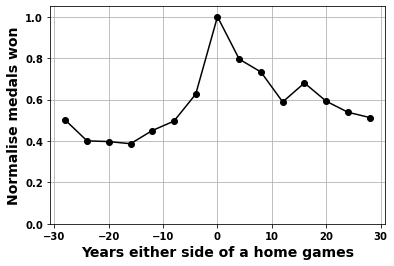

In [7]:
# If values are less than 0 put as just above zero- can occur when 

# make XY a numpy array
XY = np.array(XY)

# if interpolation is not good
XY[XY<0]=0




# create vectors for y-data either side of home-event
yallL = np.zeros((8))
yallR = np.zeros((8))

# scroll through each games
# find if the low years or high years have zeros in them
# if they don't include them in the sum 
for i,ygames in enumerate(XY):
    
    if i>11:
        if 0 not in ygames[-8:]:
            yallL[-8:]=yallL[-8:]+ygames[-8:]
        
        if 0 not in ygames[0:8]:
            yallR[0:8]=yallR[0:8]+ygames[0:8]
            

# normalise
yallL=yallL/max(yallL)
yallR=yallR/max(yallR)

# combine low and high years and only use home game year once
yall=np.concatenate([yallR[0:-1],yallL])

# plot the results
plt.subplots(figsize=(6,4))
plt.plot(xnew,yall/max(yall),'ok-')

plt.ylim([0 ,1.05])
plt.grid(True)
plt.ylabel('Normalise medals won',fontsize=14)
plt.xlabel('Years either side of a home games',fontsize=14)
# plt.plot(xnew,yall2/max(yall2),'m+--')

## Plot the effect of home games for different games


Look at the individual games plots

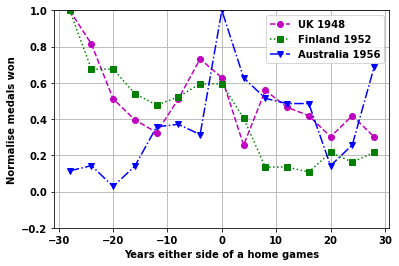

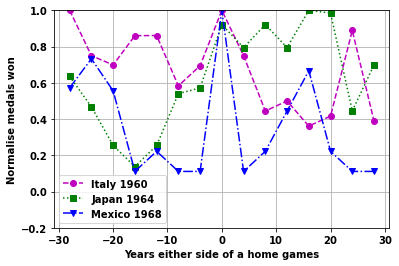

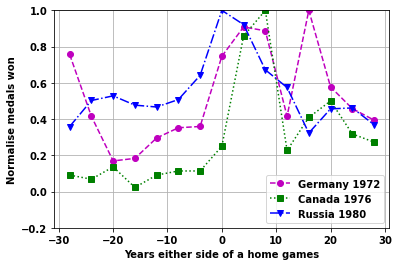

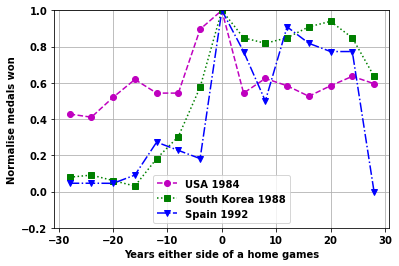

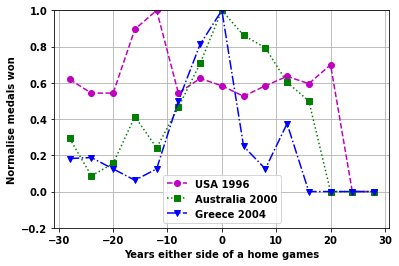

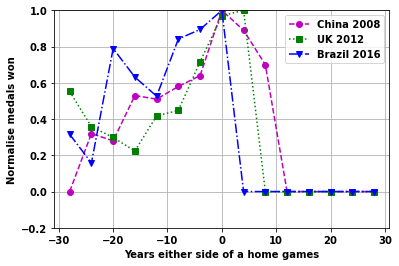

In [22]:

startnum=11

cola=['mo--','gs:','bv-.']
for i2 in range(6):
    fig,ax=plt.subplots()
    vals = np.arange(startnum,startnum+3,1,dtype=int)
    i1=0
    for i in vals: 
        plt.plot(xnew,XY[i,:],cola[i1])
        plt.ylim([-.2 ,1])
        plt.grid(True)
        plt.legend([ nation[ii] + ' ' + str(df_games.loc[ii,'Year']) for jj,ii in enumerate(vals)]);
        plt.ylabel('Normalise medals won')
        plt.xlabel('Years either side of a home games')
        i1=i1+1
    startnum=startnum+3


## Continent home games

The Olympics have mainly been held in Europe and North America. Because of this it is not possible to do the same analysis as for home country games.

Instead we can look at the difference if a games is a home continent or not.

In [551]:
continentYorN=sqldf('\
    SELECT                                     \
    home_continent,                            \
    Year,                                      \
    COUNT(*)         AS num_countries,         \
    AVG(avg_medals)  AS avg_medals             \
    FROM                                       \
      (SELECT                                  \
            Nation,home_continent, Year,       \
            AVG(number_of_medals)  AS avg_medals\
        FROM                                   \
            (SELECT                            \
               a.*,                            \
               CASE WHEN                       \
                  c.Region =a.Continent THEN 1 \
               ELSE 0 END AS home_continent    \
            FROM                               \
                df_medals2 AS a                \
            INNER JOIN                         \
                df_games AS c                  \
            ON                                 \
                c.Year=a.Year                  \
            WHERE c.Year> 1951) as inner       \
        GROUP BY                               \
            Nation, Year ) as midder           \
    GROUP BY home_continent,Year               \
     ;',locals()  ) 


continentYorN.head()

,home_continent,Year,num_countries,avg_medals
0,0,1952,20,7.450000
1,0,1956,36,11.944444
2,0,1960,21,7.095238
3,0,1964,34,13.470588
4,0,1968,35,11.285714


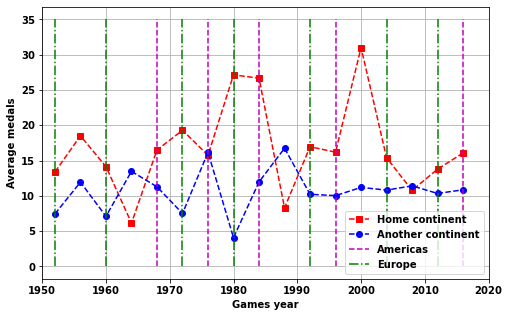

In [631]:
fig,ax=plt.subplots(figsize=(8,5))



plt.plot(continentYorN[continentYorN.home_continent==1].Year,continentYorN[continentYorN.home_continent==1].avg_medals,'rs--')
plt.plot(continentYorN[continentYorN.home_continent==0].Year,continentYorN[continentYorN.home_continent==0].avg_medals,'ob--')

plt.grid(True)
plt.ylabel('Average medals')
plt.xlabel('Games year')

# plt.plot([df_games[df_games.Region=='Asia'].Year.values,df_games[df_games.Region=='Asia'].Year.values],[0,35],color=[1,.8,.8]);

plt.plot([0,0],'m--');
plt.plot([0,0],'g-.');

plt.plot([df_games[df_games.Region=='Americas'].Year.values,df_games[df_games.Region=='Americas'].Year.values],[0,35],'m--');


plt.plot([df_games[df_games.Region=='Europe'].Year.values,df_games[df_games.Region=='Europe'].Year.values],[0,35],'g-.');


# plt.plot([df_games[df_games.Region=='Oceania'].Year.values,df_games[df_games.Region=='Oceania'].Year.values],[0,35],color=[0.7,1,.7]);

plt.xlim([1950,2020])

plt.legend(['Home continent','Another continent','Americas','Europe'])

- Not a good measure
- Instead need following columns
    - total or average medals per continent
    - Home Continent 
    - Year

In [35]:
"""
A check on the inner part of the SQL  statement

"""

sqldf('\
    SELECT *   FROM                            \
        (SELECT                                \
               a.*,                            \
               CASE WHEN                       \
                  c.Region =a.Continent THEN 1 \
               ELSE 0 END AS home_continent    \
            FROM                               \
                df_medals2 AS a                \
            INNER JOIN                         \
                df_games AS c                  \
            ON                                 \
                c.Year=a.Year                  \
            WHERE c.Year> 1951) as inner       \
     ;',locals()  ) 



,NOC,Nation,Continent,number_of_medals,Year,home_continent
0,ANZ,Australia,Oceania,11,1952,0
1,ARG,Argentina,Americas,5,1952,0
2,AUT,Austria,Europe,2,1952,1
3,BEL,Belgium,Europe,4,1952,1
4,BOH,Czech Republic,Europe,13,1952,1
...,...,...,...,...,...,...
960,UKR,Ukraine,Europe,11,2016,0
961,USA,USA,Americas,121,2016,0
962,UZB,Uzbekistan,Asia,13,2016,0
963,VEN,Venezuela,Americas,3,2016,0


In [592]:
"""
The complete SQL statement

"""

continentYorN2=sqldf('\
    SELECT \
      Year, sum(number_of_medals) AS num_medals, Continent,home_continent\
          FROM                                 \
        (SELECT                                \
               a.*,                            \
               CASE WHEN                       \
                  c.Region =a.Continent THEN 1 \
               ELSE 0 END AS home_continent    \
            FROM                               \
                df_medals2 AS a                \
            INNER JOIN                         \
                df_games AS c                  \
            ON                                 \
                c.Year=a.Year                  \
            WHERE c.Year> 1951) as inner       \
        GROUP BY Continent,Year, home_continent\
        ORDER BY Year\
     ;',locals()  ) 

continentYorN2.head()

,Year,num_medals,Continent,home_continent
0,1952,11,Africa,0
1,1952,100,Americas,0
2,1952,24,Asia,0
3,1952,308,Europe,1
4,1952,14,Oceania,0


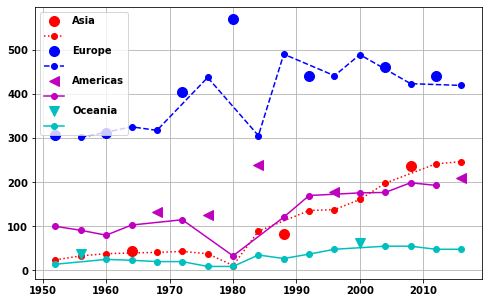

In [603]:
plt.subplots(figsize=(8,5))
region='Asia'
cond=((continentYorN2.Continent==region)&(continentYorN2.home_continent==1))
plt.plot(continentYorN2[cond].Year,continentYorN2[cond].num_medals,'or',markersize=10)
cond=((continentYorN2.Continent==region)&(continentYorN2.home_continent==0))
plt.plot(continentYorN2[cond].Year,continentYorN2[cond].num_medals,':or')

region='Europe'
cond=((continentYorN2.Continent==region)&(continentYorN2.home_continent==1))
plt.plot(continentYorN2[cond].Year,continentYorN2[cond].num_medals,'bo',markersize=10)
cond=((continentYorN2.Continent==region)&(continentYorN2.home_continent==0))
plt.plot(continentYorN2[cond].Year,continentYorN2[cond].num_medals,'b--o')

region='Americas'
cond=((continentYorN2.Continent==region)&(continentYorN2.home_continent==1))
plt.plot(continentYorN2[cond].Year,continentYorN2[cond].num_medals,'m<',markersize=10)
cond=((continentYorN2.Continent==region)&(continentYorN2.home_continent==0))
plt.plot(continentYorN2[cond].Year,continentYorN2[cond].num_medals,'m-o')

region='Oceania'
cond=((continentYorN2.Continent==region)&(continentYorN2.home_continent==1))
plt.plot(continentYorN2[cond].Year,continentYorN2[cond].num_medals,'cv',markersize=10)
cond=((continentYorN2.Continent==region)&(continentYorN2.home_continent==0))
plt.plot(continentYorN2[cond].Year,continentYorN2[cond].num_medals,'c-o')

plt.legend(['Asia','','Europe','','Americas','','Oceania',''])
plt.grid(True)

In [620]:
region='Europe'
cond=((continentYorN2.Continent==region)&(continentYorN2.home_continent==1))
asum=np.average(continentYorN2[cond].num_medals)
cond=((continentYorN2.Continent==region)&(continentYorN2.home_continent==0))
bsum=np.average(continentYorN2[cond].num_medals)

print('For {} the average medals at home continent = {:.0f} and for away continent = {:.0f}\n \
      With a ratio of {:.2f}'.format(region,asum,bsum,asum/bsum))


region='Asia'
cond=((continentYorN2.Continent==region)&(continentYorN2.home_continent==1))
asum=np.average(continentYorN2[cond].num_medals)
cond=((continentYorN2.Continent==region)&(continentYorN2.home_continent==0))
bsum=np.average(continentYorN2[cond].num_medals)

print('For {} the average medals at home continent = {:.0f} and for away continent = {:.0f}\n \
      With a ratio of {:.2f}'.format(region,asum,bsum,asum/bsum))

region='Americas'
cond=((continentYorN2.Continent==region)&(continentYorN2.home_continent==1))
asum=np.average(continentYorN2[cond].num_medals)
cond=((continentYorN2.Continent==region)&(continentYorN2.home_continent==0))
bsum=np.average(continentYorN2[cond].num_medals)

print('For {} the average medals at home continent = {:.0f} and for away continent = {:.0f}\n \
      With a ratio of {:.2f}'.format(region,asum,bsum,asum/bsum))

region='Oceania'
cond=((continentYorN2.Continent==region)&(continentYorN2.home_continent==1))
asum=np.average(continentYorN2[cond].num_medals)
cond=((continentYorN2.Continent==region)&(continentYorN2.home_continent==0))
bsum=np.average(continentYorN2[cond].num_medals)

print('For {} the average medals at home continent = {:.0f} and for away continent = {:.0f}\n \
      With a ratio of {:.2f}'.format(region,asum,bsum,asum/bsum))


For Europe the average medals at home continent = 420 and for away continent = 396
       With a ratio of 1.06
For Asia the average medals at home continent = 121 and for away continent = 103
       With a ratio of 1.18
For Americas the average medals at home continent = 177 and for away continent = 130
       With a ratio of 1.36
For Oceania the average medals at home continent = 50 and for away continent = 32
       With a ratio of 1.57


Again the above stats are not really great as 

- don't take account of changes in the average number of medals with time for a nation
- games in Oceania and Americas are often also home games

The best metric uses Europe and suggests a less than 6% increase for a home continent

